In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### seed값 고정하기


In [ ]:
def seed_everything(seed):
  random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  np.random.seed(seed)

seed_everything(42)

### Dataset 읽어오기

1. 중복되지 않는 열은 'id' column임

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/BITAmin/LG/lg_aimers.csv") # 학습용 데이터
df_test = pd.read_csv("/content/drive/MyDrive/BITAmin/LG/lg_aimers_submission.csv") # 테스트 데이터(제출파일의 데이터)

df_train.shape, df_test.shape

df_cus = df_train.groupby("customer_idx")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("customer_idx")["is_converted"].sum().reset_index()
df = pd.merge(df_cus, df_real_cus, on="customer_idx")
df["cus_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "cus_query_cnt", "is_converted_y" : "cus_converted_cnt"})
df = df[df["cus_query_cnt"]>=2]
df_train = pd.merge(df_train, df, on='customer_idx', how="left")
df_test = pd.merge(df_test, df, on='customer_idx', how="left")

df_cus = df_train.groupby("lead_owner")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("lead_owner")["is_converted"].sum().reset_index()
df = pd.merge(df_cus, df_real_cus, on="lead_owner")
df["lead_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "lead_query_cnt", "is_converted_y" : "lead_converted_cnt"})
df=df[df["lead_query_cnt"]>=2]
df_train = pd.merge(df_train, df, on='lead_owner', how="left")
df_test = pd.merge(df_test, df, on='lead_owner', how="left")

df_cus = df_train.groupby("response_corporate")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("response_corporate")["is_converted"].sum().reset_index()
df = pd.merge(df_cus, df_real_cus, on="response_corporate")
df["rc_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "rc_query_cnt", "is_converted_y" : "rc_converted_cnt"})
print(df.head())
df=df[df["rc_query_cnt"]>=2]
df_train = pd.merge(df_train, df, on='response_corporate', how="left")
df_test = pd.merge(df_test, df, on='response_corporate', how="left")

def change_value(x):
    if x == 47466:
        return 1
    else:
        return 0

df_train['customer_idx_47466'] = df_train['customer_idx'].apply(change_value)
df_test['customer_idx_r_47466'] = df_test['customer_idx'].apply(change_value)

  response_corporate  rc_query_cnt  rc_converted_cnt  rc_ratio
0              LGEAF           288               131  0.454861
1              LGEAG             8                 0  0.000000
2              LGEAP           366                47  0.128415
3              LGEAR           491                85  0.173116
4              LGEAS            33                 1  0.030303


### Data 전처리

In [ ]:
del_id=[25096]
df_train=df_train[~df_train["customer_idx"].isin(del_id)]
df_train = df_train[(df_train["business_unit"] != "CM") & (df_train["business_unit"] != "Solution")]

In [ ]:
# == 컬럼별 NA율 90% 이상 컬럼 제외 ==
# == 중복되는 행 처리 ==
df_train = df_train.drop_duplicates()

print(f"\n중복 처리 난 뒤의 train shape : {df_train.shape}")




중복 처리 난 뒤의 train shape : (53090, 39)


### bant_submit

* one_hot_encoding

* 결측치 없음

In [ ]:
print(df_train['bant_submit'].value_counts())
print('\n결측치 ' ,df_train['bant_submit'].isnull().sum())

0.50    15909
1.00    15506
0.25    10626
0.75    10605
0.00      444
Name: bant_submit, dtype: int64

결측치  0


### customer_country

* 나라별 국가별로 나누기

* 확인 결과, 상대적으로 적은 개수에서 상위 20개의 속한 나라가 많은데, 코딩하기 너무 어려워서 일단 패스

개빡쳐서 걍 하나씩 다 바꾸기로 함

* 이건 빼박 one-hot-encoding하면 좋을거 같은데 레이블 인코딩 해야할듯 ㅈㄴ 많음 ㅅㅂ

In [ ]:
# == 결측치 확인 ==
print('결측치 ratio : ', (df_train['customer_country'].isnull().sum() / len(df_train)) * 100)

# 결측치의 비율이 1.7이니 제일 많이 나온 값으로 대체할 수 있을 듯

결측치 ratio :  1.6650970050857035


In [ ]:
cus_cty = pd.DataFrame(df_train['customer_country'])

# == 결측치 없애기 ==
cus_cty = cus_cty.dropna()

# == mode값 구하기 ==
cus_cty['customer_country'] = cus_cty['customer_country'].apply(lambda x : x.split('/')[-1] if '/' in x else x)

In [ ]:
# india가 가장 많음
cus_cty_mode = cus_cty['customer_country'].value_counts().idxmax()
cus_cty_mode

'India'

In [ ]:
# 결측치에 mode(india)값 채우기
df_train['customer_country'] = df_train['customer_country'].fillna(cus_cty_mode)
df_train['customer_country'] = df_train['customer_country'].apply(lambda x : x.split('/')[-1] if '/' in x else x)

In [ ]:
pd.set_option('display.max_rows',None)
df_train['customer_country'].value_counts()

India                                                                                          16430
Brazil                                                                                          7852
United States                                                                                   3058
Mexico                                                                                          2393
Philippines                                                                                     2385
                                                                                                1935
Colombia                                                                                        1814
United Kingdom                                                                                  1449
U.A.E                                                                                           1309
Chile                                                                                      

In [ ]:
# replace를 사용하여서 해당하는 쓰레기값들 다 바꾸기

def cus_cty(df) :
  replace_values = {' India': 'India',
                    ' Brazil': 'Brazil',
                    ' United Kingdom' : 'United Kingdom',
                    ' Philippines' : 'Philippines',
                    ' United States' : 'United States',
                    ' Colombia' : 'Colombia',
                    ' U.A.E': 'U.A.E',
                    ' Poland' : 'Poland',
                    ' Egypt' : 'Egypt',
                    ' Saudi Arabia' : 'Saudi Arabia',
                    ' Chile' :'Chile',
                    ' Canada' : 'Canada',
                    ' US' : 'United States',
                    ' Mexico' : 'Mexico',
                    ' Argentina' : 'Argentina',
                    '700 Patroon Creek BlvdAlbanyNY12206' : 'United States',
                    ' Vietnam' : 'Vietnam',
                    '239 Court St, Brooklyn, NY 11201, United States' : 'United States',
                    'Little Rock, Arkansas, United States' : 'United States',
                    ' CA 91915-6002' : 'United States',
                    '430 N Hamilton RdWhitehall, OH 43213, USA' : 'United States',
                    ' 1110 Morse Rd, Columbus, Ohio, 43229, United States' : 'United States',
                    '1755 North Brown Rd. Suite 200 Lawrenceville, GA 30043' : 'United States',
                    'Miami, Florida, United States' : 'United States',
                    '1100 Lee Ave, Lafayette, LA 70501' : 'United States',
                    '85 W Main St Suite C, Canton, GA 30114' : 'United States',
                    ' Singapore' : 'Singapore',
                    '101 MetLife Way, Cary, NC, 27513 – MET1' : 'United States',
                    '7105 Northland Terrace N, Minneapolis, MN 55428' : 'United States',
                    ' CA 95814' : 'United States',
                    '1275 Sister Grove Rd Van Alstyne, TX 75495' : 'United States',
                    '100 Vestavia ParkwayBirminghamAL35216' : 'United States',
                    ' CA 92618 United States' : 'United States',
                    'Rio de Janeiro' : 'Brazil',
                    '1605 Ave. Ponce de León, Suite 400 San Juan, 00909, Puerto Rico' : 'Puerto Rico',
                    ' IL 60069' : 'United States',
                    '28001 238th St, Le Claire, IA 52753, USA' : 'United States',
                    'Grapevine, Texas, United States United States' : 'United States',
                    '700 District Dr, Itasca, IL 60143 United States' : 'United States',
                    '6398 College Blvd, Overland Park, KS 66211, United States' : 'United States',
                    ' Germany' : 'Germany',
                    '3804 W Broadway St, Ardmore, OK 73401, United States' : 'United States',
                    'New York City Metropolitan Area, United States': 'United States',
                    '2529 W Busch Blvd Suite 1000, Tampa, FL 33618, United States' : 'United States',
                    '1100 ITBProvoUT84602' : 'United States',
                    ' Telangana' : 'India',
                    ' South Africa' : 'South Africa',
                    'Jeffersonville, IN United States' : 'United States',
                    '6564 Headquarters DrPlanoTX7505' : 'United States',
                    '1817 S Washington AveTitusville, FL 32780, USA' : 'United States',
                    '63 Flushing Ave Bldg 303, Suite 804, Brooklyn, NY 11205, United States' : 'United States',
                    '717 General Booth BlvdVirginia Beach, VA 23451, USA' : 'United States',
                    '2877 Prospect Rd, Fort Lauderdale, FL 33309' : 'United States',
                    ' Türkiye' : 'Türkiye',
                    ' Algeria' : 'Algeria',
                    ' Panama' : 'Panama',
                    ' bangalore' : 'India',
                    'MI 48827' : 'United States',
                    '810 N KINGSTON DR PEORIA, IL 61604-2145' : 'United States',
                    ' OH 45215, USA' : 'United States',
                    '3801 E Willow St, Long Beach, CA 90815, EE. UU.' : 'United States',
                    ' Clinton, OK 73601' : 'United States',
                    'Ha Noi' : 'Vietnam',
                    'ARGENTINA' : 'Argentina',
                    '3100 Shore Drive Virginia Beach, VA 23451' : 'United States',
                    'Los Angeles, California, United States' : 'United States',
                    'West Caldwell NJ 07960 United States' : 'United States',
                    '881 S Division St, Buffalo, NY 14210, United States' : 'United States',
                    '12718 Kitten Trail, Hudson, FL 34669' : 'United States',
                    ' FL 33772' : 'United States',
                    '13351 Dovers St, Waverly, NE 68462, United States' : 'United States',
                    'Jacksonville Florida' : 'United States',
                    ' Ohio United States' : 'United States',
                    '1100 Lee Ave, Lafayette, LA 70501' : 'United States',
                    '6564 Headquarters DrPlanoTX75051' : 'United States',
                    ' RJ' : 'Brazil',
                    ' TX 78572 United States' : 'United States',
                    '117 Bernal Rd Ste70-422San JoseSan JoseCA95119 ' : 'United States',
                    '993 Niagara Ave, San Diego, CA 92107 United States' : 'United States',
                    'Four Embarcadero Center Suite 1400 #85, San Francisco, CA 94111 United States' : 'United States',
                    ' odisha' : 'India',
                    'lucknow' : 'India',
                    '1036 n nalder st' : 'United States',
                    ' United States 32901' : 'United States',
                    '2100 Engineer Rd, Oakland, CA 94607, United States' : 'United States',
                    'Via E. De Amicis, 23 . 90044 Carini (PA)' : 'Italy',
                    '136 S IndustrialSalineMI48176' : 'United States',
                    '335 League St S, Sulphur Springs, TX 75482' : 'United States',
                    'United States 14503.' : 'United States',
                    ' mumbai' : 'Mumbai',
                    ' gurgaon' : 'India',
                    '30 Winter Street Boston, MA 02108' : 'United States',
                    '275 John Hancock Rd. Taunton, MA, 02780' : 'United States',
                    ' MA 02062 United States' : 'United States',
                    ' Pune' : 'India',
                    'FL 33025' : 'United States',
                    'Bari, Italy' : 'Italy',
                    '8 Gay St, Christiana, PA 17509 United States' : 'United States', # 게이 뭐노 ㅋ,
                    '500 N Highway 89 North, Prescott AZ 86313 United States' : 'United States',
                    '609 Medical Center Dr. Decatur, Texas, 76234'  : 'United States',
                    '7703 Floyd Curl Dr MC 7800, San Antonio TX 78229 United States' : 'United States',
                    ' St Cloud, MN 56303' : 'United States',
                    '7581 S Franklin Way, Centennial, CO 80122, United States' : 'United States',
                    '' : 'United States',
                    ' Honduras' : 'Honduras',
                    'CARRERA 11A 94-46 EDIFICIO CHICO 3000 PISO 3 BOGOTA' : 'Columbia',
                    ' Belgium' : 'Belgium',
                    ' Romania' : 'Romania',
                    ' Israel' : 'Israel',
                    ' Jordan' : 'Jordan',
                    ' Togo': 'Togo',
                    'Netherlands Antilles' : 'Netherlands',
                    '823 Gateway Center Way, San Diego, CA 92102' : 'United States',
                    'Colombia  Cartagena' : 'Colombia',
                    'Cuiabá' : 'Brazil',
                    ' CO 80127' : 'United States',
                    ' TX 75098' : 'United States',
                    ' MO 64506' : 'United States',
                    '1222 Eastwick CirMurphy, TX 75094, United States' : 'United States',
                    '545 West 111th st Suite 7C' : 'United States',
                    'P.O. Box 291992, Port Orange, FL 32129' : 'United States',
                    'Isle of Man' : 'United Kingdom', # 아일랜드해안에 있지만, 영국왕국과 결합되어 있다함(사실 별도의 영토는 맞긴한데, 일단 영국으로)
                    'NY 10566 United States' : 'United States',
                    'GA 30039' : 'United States',
                    'Centro de Produção Audiovisual - Sesc São Paulo' : 'Brazil',
                    'Aparecida' : 'Brazil',
                    'Colombia - cartagena' : 'Colombia',
                    'Capão da canoa' : 'Brazil',
                    'São Paulo' : 'Brazil',
                    '1919 Minnesota Ct, Mississauga, ON L5N' : 'Canda',
                    '54 Sugar Creek Center Blvd #300, Sugar Land, TX 77478, United States' : 'United States',
                    'João Pessoa' : 'Brazil',
                    'PerU' : 'Peru',
                    'TN 38120' : 'United States',
                    'Richardson, Texas, United States' : 'United States',
                    'Sao Paulo' : 'Brazil',
                    '2367 N 2650 WFarr WestUT84404' : 'United States',
                    '4880 Stevens Creek BlvdSan JoseCA95129' : 'United States',
                    '3131 BriarPark Dr Suite 200HoustonTX77042' : 'United States',
                    '450 Riverchase PkwyBirminghamAL35186' : 'United States',
                    '450 Riverchase PkwyBirminghamAL35186' : 'United States',
                    '1397 Etowah DriveAtlantaGA30319' : 'United States',
                    '3 Nasson Avenue' : 'United States',
                    'Largo, Florida, United States United States' : 'United States',
                    'FL 33013' : 'United States',
                    'Bucaramanga' : 'Colombia',
                    '7610 Market St, Canton, MI 48187, United States' : 'United States',
                    '116 Village Blvd Suite 200, Princeton, NJ 08540 United States' : 'United States',
                    'Dourados' : 'Brazil',
                    'Foz de Iguaçu - PR Avenida Tancredo Neves 6731 Jardim Itaipu' : 'Brazil',
                    'St Maarten' : 'France', # 프랑스, 네델란드간 분쟁 지역 (프랑스가 더 쌤)
                    'Recife' : 'Brazil',
                    'São Paulo, Pinheiros' : 'Brazil',
                    'Cartagena' : 'Colombia',
                    'Firenze, Italy' : 'Italy',
                    ' OR 97128' : 'United States',
                    'Colombia C2: Solo información' : 'Colombia',
                    'Ironhorse Customs LLC 4443 Genella Way North Las Vegas, NV 89031' : 'United States',
                    'San Francisco, CA 94128, United States' : 'United States',
                    '14700 Caribbean Way' : 'United States',
                    'Bus Shed, 6501 Red Hook Rd #201, Nazareth, St Thomas 00802, U.S. Virgin Islands' : 'United States',
                    '1600 Rosecrans Ave bldg 7 ste 101, Manhattan Beach, CA 90266,' : 'United States',
                    ' FL 32703' : 'United States',
                    'AGOST, ALICANTE' : 'Spain',
                    'Ohio' : 'United States',
                    ' NV 89119' : 'United States',
                    ' VA 22209' : 'United States',
                    'NY' : 'United States',
                    'Θέση Πέτσα Βακαλοπούλου ΒΙΟΠΑ Παλλήνης  153 51 ' : 'Greece',
                    'SPAIN ' : 'Spain',
                    'MADRID' : 'Spain',
                    'ELCHE, ALICANTE' : 'Spain',
                    '1800 Congress Ave., Austin, TX 78701' : 'United States',
                    ' CA 92657 United States' : 'United States',
                    '9631 Liberty Rd B, Randallstown, MD 21133' : 'United States',
                    ' Benbrook, TX 76126' : 'United States',
                    'SC 29555' : 'United States',
                    '6252 E Grant Rd suite 150 Tucson, AZ 85712' : 'United States',
                    ', MO 64802 ' : 'United States',
                    ' gujarat' : 'India',
                    ' IN 46601, EE. UU.' : 'United States',
                    ' Warren, OH 44483.' : 'United States',
                    '1 Hoag Dr.' : 'United States',
                    '210 Route 4 East Fl 4' : 'United States',
                    '21903 Ranier Ln' : 'United States',
                    ' NY 11358' : 'United States',
                    ' CA 95618' : 'United States',
                    'New Hampshire' : 'United States',
                    'GA 31405' : 'United States',
                    ' Wyckoff, NJ 07481, USA' : 'United States',
                    ' 750 Florida Central Parkway Suite #100 Longwood, FL 32750' : 'United States',
                    '  FL 33404' : 'United States',
                    '101 Clyde Ave Longwood, FL 32750, USA' : 'United States',
                    'CA' : 'United States',
                    ' IL 61615' : 'United States',
                    'Herndon, VA 20170' : 'United States',
                    '724 W Business US Highway 60, Dexter, MO 63841,' : 'United States',
                    ' Square at, 2662 Gateway Rd Suite 165, Carlsbad, CA 92009' : 'United States',
                    '1156 W Armitage Ave suite b, Chicago, IL 60614, US.' : 'United States',
                    ' MO 63103, USA' : 'United States',
                    ' MO 63103' : 'United States',
                    'GRAN CANARIAS PLAYA DEL INGLES' : 'Spain',
                    'CACERES' : 'Spain',
                    '4278 S Buffalo St  Orchard Park, NY 14127' : 'United States',
                    '1775 Liberty Dr, Fort Belvoir, VA 22060, United States' : 'United States',
                    '8569 Sudley Rd Ste C Historic District, Manassas, VA 20110, USA' : 'United States',
                    ' MA 02780' : 'United States',
                    'MN 55024' : 'United States',
                    'Delmar, NY 12054 United States' : 'United States',
                    ' IL 60638 United States' : 'United States',
                    ' MO 64108' : 'United States',
                    ' CA 92078' : 'United States',
                    ' IL 60563United States' :  'United States',
                    'SD 57751' : 'United States',
                    '990 S Madera Ave, Kerman, CA 93630, United States' : 'United States',
                    '135 Broadway, Schenectady, NY 12305, United States' : 'United States',
                    '1491 Furnace St, Montgomery, AL 36104, United States' : 'United States',
                    '1385 N Weber Rd, Romeoville, IL 60446,' : 'United States',
                    '463 Industrial Park Rd, Elysburg, PA 17824, US' : 'United States',
                    '  CA 94555 United States' : 'United States',
                    ' UT 84116' : 'United States',
                    '990 Biscayne Dr, Concord, NC 28027, United States' : 'United States',
                    'Nicolosi (CT), Italy' : 'Italy',
                    ' FL 33442' : 'United States',
                    'FL 33716' : 'United States',
                    '3440 Rockefeller Ct Waldorf, MD 20602' : 'United States',
                    ' Arlington, NY 12603' : 'United States',
                    '65 Grove Street, Suite 204  Watertown, MA 02472' : 'United States',
                    '13854 Lakeside Cir Sterling Heights, MI 48313' : 'United States',
                    '9110 Forest CrossingThe WoodlandsTX77381' : 'United States',
                    ' OK 73601 United States' : 'United States',
                    'Hacienda Heights, California, United States' : 'United States',
                    ' mumbai' : 'Mumbai',
                    ' Connecticut United States' : 'United States',
                    'Caldwell, New Jersey, United States United States' : 'United States',
                    'Gujarat' : 'India',
                    ' Chennai' : 'India',
                    ' Jamaica, NY 11417, USA' : 'United States',
                    ' indore' : 'India',
                    'US Virgin Islands' : 'United Kingdom', # 영국이랑 가까워서 영국으로 해놓음
                    ' KS 66217' : 'United States',
                    ' NJ 07013' : 'United States',
                    ' TX 77024' : 'United States',
                    '30 Cambria Ave, Pleasantville, NJ 08232' : 'United States',
                    '4278 S Buffalo St Orchard Park, NY 14127' : 'United States',
                    '723 S Valley Way, Palmer, AK 99645' : 'United States',
                    'Zip 98433' : 'United States',
                    ' bhilwara' : 'India',
                    ' ND' : 'United States', # 노스다코타주(미국 도시이름) 줄임말 같음
                    ' VT 05672' : 'United States',
                    '800 3rd Ave 3rd floor, New York, NY 10022' : 'United States',
                    ' BR' : 'Brazil', # 브라질 iso국가부호
                    ' kerela' : 'India',
                    ' uttar pradesh' : 'India',
                    ' Anand Vihar Delhi' : 'India',
                    ' hyderabad' : 'India',
                    "Via dell'informatica 10 - 37036 San Martino Buon Albergo (Veneto), Italy" : ' Italy',
                    'Belo Horizonte' : 'Brazil',
                    '15806 Longship Ct' : 'United States',
                    '2350 Airport FrwyBedfordTX76022' : 'United States',
                    '1999 S Bascomb AveSuite 1000CampbellCA95008' : 'United States',
                    '9716 McFarring DrFort WorthTX76244' : 'United States',
                    '200 cabelLouisvilleKY40206' : 'United States',
                    '1112 Badger Vine LaneArlingtonTX76005' : 'United States',
                    '6111 W Plano Pkwy #2100PlanoTX75093' : 'United States',
                    '100 Sabine River Dr.HuttoTX78634' : 'United States',
                    '6300 Harry Hines BlvdSte. 1400DallasTX75235' : 'United States',
                    '100 first stSan FranciscoCA94015' : 'United States',
                    '899 Kifer RoadSunnyvaleCA94086' : 'United States',
                    '2217 HOUSTON DRIVEMelissaTX75454' : 'United States',
                    '829 Jackson ave' : 'United States',
                    '3027 West Bay Villa Ave' : 'United States',
                    '126 Diablo Ranch Court' : 'United States',
                    '1537 Rolling Hills Dr.' : 'United States',
                    '1715 Forest Cove Drive,  Apt 201' : 'United States',
                    '410 Baylor StAustinTX78703' : 'United States',
                    '9111 cypress waters blvdDallasTX75038' : 'United States',
                    '9420 West Sam Houston Pkwy NHoustonTX77018' : 'United States',
                    '6 Kimball LaneLynnfieldMA1940' : 'United States',
                    '9820 Northcross Center CtHuntersvilleNC28078' : 'United States',
                    '9800 S. Monroe StreetSandyUT84070' : 'United States',
                    '2475 Washington BlvdOgdenUT84401' : 'United States',
                    '400 Centre StNewtonMA2458' : 'United States',
                    '400 Centre StreetNewtonMA2458' : 'United States',
                    '36 Margin StPeabodyMA1960' : 'United States',
                    '77 Massachusetts AveCambridgeMA2139' : 'United States',
                    '160 Gould St Ste 300, Needham Heights, Massachusetts 02494NeedhamMA2721' : 'United States',
                    '9 Landsdowne StreetBostonMA2215' : 'United States',
                    '1209 Derby Run Carrollton, TX 75007CarrolltonTX75007' : 'United States',
                    'One Constitution RoadBostonMA2129' : 'United States',
                    '252 Beech AvenueMelroseMA2176' : 'United States',
                    '5301 Stevens Creek BlvdSanta ClaraCA95051' : 'United States',
                    '230 Highland Ave, Suite 531SomervilleMA2143' : 'United States',
                    '7700 West Sunrise BlvdPlantationFL33322' : 'United States',
                    '602 Saber Creek Drive' : 'United States',
                    '11330 Clay RdHoustonTX77041' : 'United States',
                    '1 Skyview drFort WorthTX76155' : 'United States',
                    '416 Panzano Drive' : 'United States',
                    '5501 Headquarters DrPlanoTX75024' : 'United States',
                    '2266 Palmer Dr.' : 'United States',
                    '1380 Enterprise Dr' : 'United States',
                    '6601 Carroll Highlands Rd' : 'United States',
                    '275 Mishawum Road' : 'United States',
                    '222 Maxine Dr' : 'United States',
                    '2900 Highway 280Suite 250BirminghamAL35223' : 'United States',
                    '305 John Street' : 'United States',
                    ' Kenya' : 'Kenya',
                    ' MA 01851' : 'United States',
                    '600 5th Street' : 'United States',
                    ' IL 60191' : 'United States',
                    '' : 'United States',
                    '' : 'United States',
                    '' : 'United States',
                    'Cra. 51 #12 sur-75, San Fernando, Itagüi, Medellín, Guayabal, Medellín, Antioquia, Colombia' : 'Colombia',
                    ' Switzerland' : 'Switzerland',
                    ' Serbia' : 'Serbia',
                    ' Nigeria' : 'Nigeria',
                    ' Denmark' : 'Denmark',
                    ' Ireland' : 'Ireland',
                    ' Botswana' : 'Botswana',
                    ' Oman' : 'Oman',
                    ' Thailand' : 'Thailand',
                    ' Indonesia' : 'Indonesia',
                    '3000 Montour Church Road' : 'United States',
                    '9820HuntersvilleNC28078' : 'United States',
                    '152 Bowdoin Street' : 'United States',
                    'PO Box 112292CarrolltonTX75011' : 'United States',
                    '825 Eastlake Ave E' : 'United States',
                    '955 Powell Ave SW' : 'United States',
                    '2047  w summerdale ave' : 'United States',
                    '1560 Chance Ct' : 'United States',
                    '8454 Muirwood TrlFort WorthTX76137' : 'United States',
                    '1503 LBJ ParkwaySuite 700Farmers BranchTX75234' : 'United States',
                    '7673 HEMPSTON CIR' : 'United States',
                    '1808 Lithgow RdCelinaTX75009' : 'United States',
                    '1001 Main St' : 'United States',
                    '1909 Forest Knoll DrHooverAL35244' : 'United States',
                    '106 Lakeview DrHomewoodAL35209' : 'United States',
                    '24082 Carmel Dr' : 'United States',
                    '417 20th St NBirminghamAL35203' : 'United States',
                    '594 Howard StSan FranciscoCA94105' : 'United States',
                    '594 Howard StSan FranciscoCA94106' : 'United States',
                    '31700 Temecula Parkway, Temecula CA 92592 United States' : 'United States',
                    '300 East Park Drive' : 'United States',
                    'Manaus' : 'Brazil',
                    'SPAIN' : 'Spain',
                    ', MO 64802' : 'United States',
                    'Columbia' : 'Colombia',
                    'Canda' : 'Canada',
                    'Θέση Πέτσα Βακαλοπούλου ΒΙΟΠΑ Παλλήνης  153 51' : 'Greece',
                    '117 Bernal Rd Ste70-422San JoseSan JoseCA95119' : 'United States',
                    '6005 Commerce Dr. Ste. 300' : 'United States',
                    '17215 Welby Way' : 'United States',
                    ' Italy' : 'Italy',
                    '45 n 200 wWillardUT84340' : 'United States',
                    'Swaziland' : 'Switzerland',
                    'Nevada' : 'United States',
                    '1100 Lee Ave, Lafayette, LA 70501,' : 'United States',
                    ' MO 64108.' : 'United States',
                    'mumbai' : 'Mumbai',
                    'Barranquilla' : 'Colombia',
                    'UAE Dubai' : 'U.A.E',
                    'COLOMBIA' : 'Colombia',
                    'Türkiye' : 'Turkey',
                    'EGYPT' : ' Eqypt',
                    'Democratic Republic of the Congo' : 'Congo',
                    'St Kitts' : 'Saint Kitts and Nevis',
                    'Antigua' : 'Antigua and Barbuda',
                    'Ivory Coast' : "Cote d'Ivoire",
                    'British Virgin Islands' : 'United Kingdom',
                    '85 W Main St Suite C, Canton, GA 30114,' : 'United States',
                    'Turks and Caicos Islands' : 'United Kingdom'
                    }

  df['customer_country'] = df['customer_country'].replace(replace_values)
  return df

df_train = cus_cty(df_train)
df_test = cus_cty(df_test)


In [ ]:
pd.set_option('display.max_rows',None)
cty_cnt = df_train['customer_country'].value_counts()

df_train['customer_country'] = df_train['customer_country'].apply(lambda x: 'others' if cty_cnt[x] < 2 else x)

df_train['customer_country'].value_counts()

India                          16712
Brazil                          7926
United States                   5316
Philippines                     2416
Mexico                          2397
Colombia                        1890
United Kingdom                  1491
U.A.E                           1342
Chile                           1075
Saudi Arabia                    1056
Peru                             987
Italy                            847
Germany                          784
Poland                           728
Spain                            540
Turkey                           521
Vietnam                          512
Egypt                            488
Argentina                        475
Australia                        321
Panama                           309
Ecuador                          265
France                           264
Canada                           260
Indonesia                        253
Hong Kong                        247
Singapore                        178
S

In [ ]:
len(df_train['customer_country'].value_counts()), len(df_test['customer_country'].value_counts()),

(152, 2467)

### business_unit

* 결측치 없음

* one-hot-encoding

* cm은 1개이므로 해당 행 지우기

In [ ]:
df_train['business_unit'].value_counts()

# == CM 삭제 ==
bus_condition = df_train['business_unit'] == 'CM'
df_train = df_train[~bus_condition]

df_train['business_unit'].value_counts()

ID    23407
AS    21775
IT     7908
Name: business_unit, dtype: int64

## customer_idx

* 고객의 회사명

* 아직 전처리 x

## customer_type

* 결측치 41357개

* customer의 국가와 type 비교해보기 (비율이 너무 다양해서 실패)

* 석우꺼랑 똑같이 함

*  **근데, others가 너무 많음 **

* 원 핫 인코딩


In [ ]:
def preprocess_customer_type(x):
    if x == 'End-Customer' :
        return 'End Customer'
    elif x == 'Specifier/ Influencer' :
        return 'Specifier / Influencer'
    elif x =='Other' or x=='Others':
        return 'Etc.'
    elif x == 'Software/Soultion Provider' :
        return 'Software / Solution Provider'
    else:
        return x

df_train['customer_type'] = df_train['customer_type'].apply(preprocess_customer_type)

df_train['customer_type'].value_counts()

End Customer                    10097
Specifier / Influencer           2366
Channel Partner                  1282
Service Partner                   316
Solution Eco-Partner              128
Installer/Contractor               42
Corporate                          28
Etc.                               20
Engineer                           18
HVAC Engineer                      17
Technician                         16
Consultant                         15
Developer                          14
Software/Solution Provider          7
Manager / Director                  7
End-user                            7
Home Owner                          6
Homeowner                           5
Architect/Consultant                5
Installer                           5
Interior Designer                   5
Reseller                            4
Distributor                         4
Dealer/Distributor                  2
Software / Solution Provider        1
Technical Assistant                 1
Commercial e

In [ ]:
def preprocess_customer_type(df):
    # 'End-Customer'를 'End Customer'로 변경
    df['customer_type'] = df['customer_type'].replace('End-Customer', 'End Customer')

    # 가장 많이 나오는 변수 상위 5개를 저장
    top3_types = df['customer_type'].value_counts().index[:5]

    # 상위 3개에 속하지 않는 경우 'others'로 변경
    df['customer_type'] = df['customer_type'].apply(lambda x: x if x in top3_types else 'others')

    return df
df_train = preprocess_customer_type(df_train)
df_test = preprocess_customer_type(df_test)

df_train['customer_type'].value_counts()

others                    38901
End Customer              10097
Specifier / Influencer     2366
Channel Partner            1282
Service Partner             316
Solution Eco-Partner        128
Name: customer_type, dtype: int64

## Enterprise

* Enterprise : 대기업

* SMB : 중소기업

* 원 핫 인코딩


In [ ]:
df_train['enterprise'].value_counts()

Enterprise    34335
SMB           18755
Name: enterprise, dtype: int64

## historical_existing_cnt

* 전처리 아직 안함

## customer_job

* 원 핫 인코딩

이거 분야가 너무 많으니까 대학교 전공별로 (해당되지 않는 것은 냅뒀음)

* 예체능 : fine

* 인문대 : liberal

* 보건 및 의료 : health

* 사범 : education

* 경영 : management

* 농업 : agriculture

* 공학 : engineering

* 사회 : social

* 자연계열 : science

In [ ]:
def cus_job(df):
  replace_job = {'arts and design' : 'fine',
                 'consulting' : 'liberal',
                 'business development' : 'management',
                 'marketing' : 'management',
                 'entrepreneurship' : 'management',
                 'information technology' : 'engineering',
                 'administrative' : 'social',
                 'sales' : 'social',
                 'operations' : 'management',
                 'media and communication' : 'social',
                 'healthcare services' : 'health',
                 'product management' : 'management',
                 'finance' : 'management',
                 'accounting' : 'management',
                 'support' : 'management', # 비즈니스 지원으로 봤음(다를 수 도 있음)
                 'graphic/color art' : 'fine',
                 'real estate' : 'management',
                 'film production' : 'fine',
                 '3d/vfx art' : 'fine',
                 'clinical specialist' : 'health',
                 'radiology professional' : 'health',
                 'medical imaging specialist' : 'health',
                 'medical solution provider' : 'health',
                 'community and social services' : 'social',
                 'surgery professional' : 'health',
                 'pathologist' : 'health',
                 'curation' : 'fine',
                 'art and design' : 'fine',
                 'general management' : 'management',
                 'sonstiges' : 'other', # 독일어로 other이란 뜻
                 'technical' : 'engineering',
                 'kreation_und_design' : 'fine',
                 'director' : 'fine',
                 'arquitecto/consultor' : 'engineering',
                 'designer' : 'fine',
                 'executive' : 'management',
                 'vertrieb' : 'management',
                 'engineering & technical' : 'engineering',
                 'engineer' : 'engineering',
                 'ceo/founder' : 'management',
                 'architect' : 'engineering',
                 'medien_und_kommunikation' : 'social',
                 'gm' : 'management', # general management의 약자인거 같음(아닐 수 도 있음)
                 'finanzen' : 'management',
                 'ceo' : 'management',
                 'otro' : 'other',
                 'arts_and_design' : 'fine',
                 'information_technology' : 'engineering',
                 'installer' : 'engineering',
                 'community_and_social_services' : 'social',
                 'revendedor' : 'management',
                 'research & development' : 'engineering',
                 'consultant' : 'social',
                 'surgery professional' : 'health',
                 'it manager' : 'engineering',
                 'clinic' : 'health',
                 'coordinator' : 'management',
                 'chief engineer' : 'engineering',
                 'advertising' : 'management',
                 'medical solution  provider' : 'health',
                 'adminisztráció' : 'management',
                 'integrador' : 'integrator',
                 'egyéb' : 'other',
                 'omputing & it' : 'engineering',
                 'vendite' : 'management',
                 'media_e_comunicazione' : 'social',
                 'business_development' : 'management',
                 'it director' : 'engineering',
                 'account management' : 'management',
                 'pm' : 'management',
                 'it' : 'engineering',
                 'information technology​' : 'engineering',
                 'healthcare_services' : 'health',
                 'general contractor' : 'engineering',
                 'pénzügy' : 'management',
                 'educator' : 'education',
                 'design' : 'fine',
                 'higher education (college & university)' : 'education',
                 'amministrativo' : 'management',
                 'av tech' : 'engineering',
                 'director of it' : 'engineering',
                 'radiology  professional' : 'health',
                 'média_és_kommunikáció' : 'social',
                 'medical imaging  specialist' : 'engineering',
                 'engineering & technical executive ' : 'engineering',
                 'művészet_és_design' : 'fine',
                 'sales operations' : 'management',
                 'healthcare professionals' : 'health',
                 'administrative assistant' : 'management',
                 'healthcare professionals' : 'health',
                 'it - information technology' : 'engineering',
                 'other stores' : 'other',
                 'marketing operations' : 'management',
                 'project architect' : 'engineering',
                 'sales executive' : 'management',
                 'coo' : 'management',
                 'tech' : 'engineering',
                 'marketing executive' : 'management',
                 'technical director' : 'engineering',
                 'administration' : 'management',
                 'interior designer' : 'fine',
                 'recommend (you recommend specific products or technologies for the solution)' : 'engineering',
                 'operations executive' : 'management',
                 'it/software' : 'engineering',
                 'event marketing' : 'management',
                 'collaboration & web apps ' : 'engineering',
                 'sales engineering' : 'engineering',
                 'hr' : 'management',
                 'field marketing' : 'management',
                 'altro' : 'other',
                 'pacs administrator' : 'management',
                 'értékesítés' : 'management',
                 'technical marketing ' : 'engineering',
                 'account exec/manager' : 'management',
                 'admin' : 'management',
                 'medios_de_comunicación' : 'social',
                 'it specialist' : 'engineering',
                 'fashion' : 'fine',
                 'medical solution provider​' : 'health',
                 'graphic design' : 'fine',
                 'autres' : 'other',
                 'railway & metro station' : 'other',
                 'üzemeltetés' : 'management',
                 'arte_e_design' : 'fine',
                 'electronics & telco' : 'engineering',
                 'product_management' : 'management',
                 'si' : 'engineering', # si업체?
                 'display' : 'engineering',
                 'surgery professional​' : 'health',
                 'computing & it' : 'engineering',
                 'engineering & technical executive' : 'engineering',
                 'technical marketing' : 'engineering',
                 'designer/pm/gc' : 'fine',
                 'solution engineer' : 'engineering',
                 'doctor' : 'health',
                 'field / outside sales' : 'management',
                 'emerging technology / innovation' : 'engineering',
                 'manufacturing factory / plant' : 'engineering',
                 'broadcasting & media' : 'fine',
                 'architect ass interiores' : 'fine',
                 'manger' : 'management',
                 'energy' : 'engineering',
                 'underboss' : 'management',
                 'it support' : 'engineering',
                 'managing partner' : 'management',
                 'research products and prices' : 'management',
                 'it tech.' : 'engineering',
                 'it admin' : 'management',
                 'chief eng.' : 'engineering',
                 'it hardware technician' : 'engineering',
                 'lead engineer' : 'engineering',
                 'technology consultant' : 'engineering',
                 'electrical contractor' : 'engineering',
                 'design/build' : 'fine',
                 'regional director of operations' : 'management',
                 'media and communications' : 'social',
                 'systems design' : 'fine',
                 'designers' : 'fine',
                 'design/purchaser' : 'fine',
                 'project engineer' : 'engineering',
                 'design consultant' : 'fine',
                 'technical / decision maker' : 'engineering',
                 'instructor' : 'education',
                 'r&d project manager' : 'engineering',
                 'electronics evaluator' : 'engineering',
                 'chief of engineering' : 'engineering',
                 'design engineer' : 'engineering',
                 'engineering, design, and install' : 'other',
                 'software solution' : 'engineering',
                 'colorist' : 'fine',
                 'otros' : 'other',
                 'photographer' : 'fine',
                 'developer' : 'engineering',
                 'arte y diseño' : 'fine',
                 'finanzas' : 'management',
                 'artist, lead on equipment selection' : 'fine',
                 'execution' : 'management',
                 'system installer' : 'engineering',
                 'manufacturer' : 'management',
                 'site manager' : 'engineering',
                 'tv studio manager' : 'management',
                 'office manager' : 'management',
                 'engineering director' : 'engineering',
                 'tech service' : 'engineering',
                 'comanager' : 'management',
                 'equipment custodian' : 'management',
                 'display screen from control' : 'engineering',
                 'accounts payable' : 'management',
                 'equipment and app provider' : 'engineering',
                 'research and developement' : 'engineering',
                 'hardware' : 'engineering',
                 'salesman' : 'management',
                 'hardware design engineer' : 'engineering',
                 'deputy cio' : 'management',
                 'technical sales' : 'management',
                 'product research' : 'engineering',
                 'parts coordinator' : 'management',
                 'senior design engineer' : 'engineering',
                 'it dairector' : 'engineering',
                 'informatics, touch capability' : 'engineering',
                 'teacher' : 'education',
                 'solutions architect' : 'engineering',
                 'others' : 'other',
                 'programm-_und_projektmanagement' : 'program and project management',
                 'manager' : 'program and project management',
                 'project manager' : 'program and project management',
                 'general manager' : 'program and project management',
                 'decision maker' : 'program and project management',
                 'program_and_project_management' : 'program and project management',
                 'procurement' : 'program and project management',
                 'operations manager' : 'program and project management',
                 'project coordinator' : 'program and project management',
                 'projektmenedzsment\tprogram and project management' : 'program and project management',
                 'sales manager' : 'program and project management',
                 'program_and_project_manager' : 'program and project management',
                 'project lead' : 'program and project management',
                 'program-_és_projektmenedzsment' : 'program and project management',
                 'sourcing / procurement' : 'program and project management',
                 'general manager (decision maker)' : 'program and project management',
                 'project designer' : 'program and project management',
                 'project team member' : 'program and project management',
                 'purchasing manager' : 'program and project management',
                 'procurement specialist' : 'program and project management',
                 'product marketing' : 'program and project management',
                 'project director' : 'program and project management',
                 'program-_és_projektmenedzsment' : 'program and project management',
                 'projectr mgmt' : 'program and project management',
                 'product researcher' : 'program and project management',
                 'a/v project manager' : 'program and project management',
                 'managing director' : 'program and project management',
                 'project manager/designer' : 'program and project management',
                 'av project manager' : 'program and project management',
                 'facility manager' : 'program and project management',
                 'project manager / principal' : 'program and project management',
                 'managing contractor' : 'program and project management',
  }
  df['customer_job'] = df['customer_job'].replace(replace_job)

  return df

# 결측치는 unknown으로 채우기
df_train['customer_job'].fillna('unknown', inplace = True)

df_train = cus_job(df_train)

In [ ]:
cty_jobs = df_train['customer_job'].value_counts()

df_train['customer_job'] = df_train['customer_job'].apply(lambda x: 'other' if cty_jobs[x] < 110 else x)


df_train['customer_job'].value_counts()

unknown                           16253
management                         7624
engineering                        7536
social                             5932
other                              5714
education                          2178
fine                               2100
purchasing                         1709
health                             1500
liberal                            1221
program and project management     1057
legal                               147
research                            119
Name: customer_job, dtype: int64

## lead_desc_length

* 전처리 아직 안함

In [ ]:
df_train['lead_desc_length'].value_counts()

3       9569
14      2777
2        870
10       843
4        792
5        743
1        712
11       669
23       651
18       606
7        605
35       551
17       551
15       544
12       543
9        543
8        507
13       488
16       475
20       466
6        466
22       459
24       457
29       452
28       443
33       440
21       428
19       428
34       408
37       397
27       385
30       373
26       363
25       355
31       343
32       340
36       330
38       308
43       288
41       287
46       279
40       267
42       257
50       247
39       245
49       244
48       240
45       237
47       237
51       237
44       225
57       221
52       216
56       214
60       212
58       209
53       202
55       195
59       192
73       189
63       187
54       187
64       186
70       177
68       172
61       172
72       169
66       169
69       163
65       162
67       161
77       159
80       158
76       155
81       149
62       147
82       147

## inquiry_type

In [ ]:
df_train['historical_existing_ratio'] = df_train['historical_existing_cnt'] / df_train['cus_query_cnt']
df=df_train.groupby('customer_idx')['historical_existing_ratio'].mean().reset_index()
df_test = pd.merge(df_test, df, on='customer_idx', how='left')


from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# 'lead_desc_length' 열에 대해 MinMaxScaler를 적용하고, 결과를 새로운 열에 저장
df_train['lead_desc_length'] = scaler.fit_transform(df_train[['lead_desc_length']])
df_train['lead_desc_length'] = scaler.fit_transform(df_train[['lead_desc_length']])

df_train['length_ratio'] = df_train['bant_submit']*df_train['lead_desc_length']
df_test['length_ratio'] = df_test['bant_submit']*df_test['lead_desc_length']

In [ ]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

    # 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    # "business_area",
    # "business_unit",
    # "customer_type",
    # "enterprise",
    # "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

#원핫 인코딩할 칼럼들
one_hot_columns=[
    "bant_submit",
    # "customer_country",
    # "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    # "inquiry_type",
    # "product_category",
    # "product_subcategory",
    # "product_modelname",
    # "customer_country.1",
    # "customer_position",
    # "response_corporate",
    # "expected_timeline",
]

df_all = pd.concat([df_train, df_test])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

df_all = pd.get_dummies(df_all, columns=one_hot_columns)

<ipython-input-82-5b19553ab246>:54: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df_all = pd.concat([df_train, df_test])


In [ ]:
drop_columns=[
            #   "id_strategic_ver",
            #   "it_strategic_ver",
            #   "idit_strategic_ver",
            #   "ver_cus",
            #   "ver_pro",
            # "ver_win_rate_x",
            # "ver_win_ratio_per_bu",
            # "expected_timeline",
            # "com_reg_ver_win_rate",
            # 'historical_existing_cnt'
            'lead_owner'
            ]

for column in drop_columns:
    df_all.drop(columns=column, inplace=True)

df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]

df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

df_train=df_train.drop(columns="id")

X_train= df_train.drop("is_converted", axis=1)
y_train= df_train["is_converted"]
X_test = df_test.drop(["is_converted", "id"], axis=1)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [ ]:
from sklearn. model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import f1_score

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

oof_val_preds = np.zeros(X_train.shape[0])
oof_test_preds = np.zeros(X_test.shape[0])

def f1score(preds, d_train):
    labels = d_train.get_label()
    return 'f1', f1_score(labels, np.round(preds)), True

params={
    'objective': 'binary',
    'learning_rate':0.01,
    "random_state":0,
    "early_stopping_rounds":100,
    "scale_pos_weight": 22
}

f1_score_list=[]
feature_importance_list=[]
threshold_list=[]

for idx, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    print('#'*40, f'폴드{idx+1} / 폴드{folds.n_splits}', "#"*40)
    X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    d_train = lgb.Dataset(X_tr, y_tr)
    d_valid = lgb.Dataset(X_val, y_val)

    lgb_model = lgb.train(params=params,
                          train_set=d_train,
                          num_boost_round=1000,
                          valid_sets=d_valid,
                          feval=f1score)

    oof_test_preds += lgb_model.predict(X_test) / folds.get_n_splits()
    oof_val_preds[valid_idx] += lgb_model.predict(X_val)

    f1 = f1_score(y_val, np.round(oof_val_preds[valid_idx]))
    f1_score_list.append(f1)
    print(f'폴드 {idx+1} f1 score: {f1}\n')

    feature_importance_list.append(lgb_model.feature_importance())

print(f'검증 평균 f1 score: {np.mean(f1_score_list)}')
# 검증 평균 f1 score:  0.71

######################################## 폴드1 / 폴드5 ########################################
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1772, number of negative: 40700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.169814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3307
[LightGBM] [Info] Number of data points in the train set: 42472, number of used features: 74
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041722 -> initscore=-3.134119
[LightGBM] [Info] Start training from score -3.134119
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.0959049	valid_0's f1: 0.715945
폴드 1 f1 score: 0.7159450897571

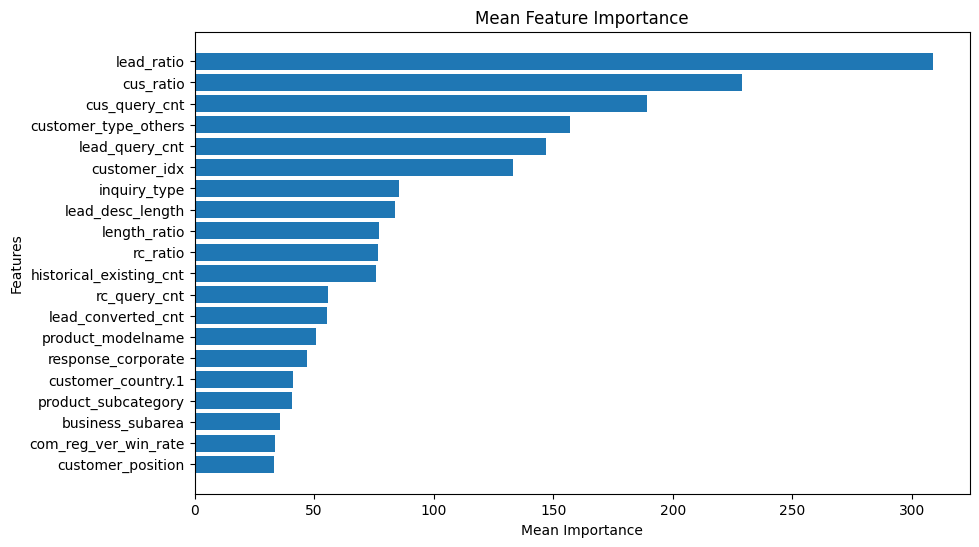

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 특징 중요도와 특징 이름을 정렬
top_features = 20
sorted_indices = np.argsort(-np.mean(feature_importance_list, axis=0))[::-1]
sorted_feature_names = [lgb_model.feature_name()[i] for i in sorted_indices][-top_features:]
sorted_mean_importance = np.mean(feature_importance_list, axis=0)[sorted_indices][-top_features:]

# 바 차트 그리기
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_mean_importance)
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('Mean Feature Importance')
plt.show()

In [ ]:
test_pred = np.where(oof_test_preds >= 0.3, 1, 0)

In [ ]:
sum(test_pred) # True로 예측된 개수 2064

2194

In [ ]:
df_test["is_converted"] = test_pred

# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("/content/drive/MyDrive/BITAmin/LG/lg_aimers_submission.csv")
df_sub["is_converted"]=df_test["is_converted"]

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)